# Preparations

##  Modules Required

In [32]:
# !pip install numpy pandas geotext tweet-preprocessor nltk wordcloud plotly pycountry

## Mount Google Drive

In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import required modules

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
from textblob import TextBlob
from geotext import GeoText
import nltk
import plotly.graph_objects as go
from wordcloud import WordCloud
import pycountry

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mukul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Configurations

In [36]:
IS_SAMPLE_ANALYSIS = False
TARGET = 'tesla'
TARGET_NAME = TARGET
if IS_SAMPLE_ANALYSIS:
    TARGET_NAME += '_sample'
FIGURE_SIZE = (12,7)
# FOLDER_LOCATION = '/content/drive/My Drive/Projects/Twitter Data Sentiment Analysis/data/'
# FOLDER_LOCATION = '/content/drive/My Drive/DM/'
FOLDER_LOCATION = '../data/'
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Load Data

In [37]:
tweets = pd.read_csv(FOLDER_LOCATION + TARGET_NAME + '.csv', index_col=0, converters={i: str for i in range(0, 8)})

In [38]:
tweets.tail()

,text,timestamp,user,tweet_source,tweet_id,source_device,clean_text,country
70149,@thirdrowtesla God I'm so sick of this. Every ...,1584861154,AerialEng,1241528563398049793,1241623788359315458,Twitter for iPhone,god i'm so sick of this. every tesla thread i ...,NaN
70150,Yo who is down to key a tesla tonight,1584861236,Ex__lion_tamer,1241624132187344898,1241624132187344898,Twitter Web App,yo who is down to key a tesla tonight,NaN
70151,@d4t4wr4ngl3r @thirdrowtesla That doesn't chan...,1584861304,AerialEng,1241538576686465025,1241624417924341760,Twitter for iPhone,that doesn't change the fact that the account ...,NaN
70152,Addressing #COVID19: \r\nElon Musk + Tesla + M...,1584861370,MDT_RMS_EMEA,1241624697139351552,1241624697139351552,Khoros Marketing,addressing covid19 elon musk tesla medtronic c...,CH
70153,"@sacramentotesla @yashar ""all he said was that...",1584861397,statsboye,1241624808774709249,1241624808774709249,Twitter Web App,"""all he said was that panic is dumb"" then that...",NaN


# Feature Creation

## 'is_retweet' from 'tweet_source' and 'tweet_id'

In [39]:
def is_retweet(x):
    return x[0] != x[1]

In [40]:
tweets['is_retweet'] = tweets[['tweet_source','tweet_id']].apply(lambda x: is_retweet(x), axis=1)

In [41]:
tweets[['tweet_source','tweet_id','is_retweet']].tail()

,tweet_source,tweet_id,is_retweet
70149,1241528563398049793,1241623788359315458,True
70150,1241624132187344898,1241624132187344898,False
70151,1241538576686465025,1241624417924341760,True
70152,1241624697139351552,1241624697139351552,False
70153,1241624808774709249,1241624808774709249,False


## 'datetime' from 'timestamp'

In [42]:
def get_datetime(ts):
    return datetime.fromtimestamp(int(ts))

In [43]:
# Add datetime column
tweets['datetime'] = tweets['timestamp'].apply(lambda x: get_datetime(x))

# Analysis

## Tweet distribution over time

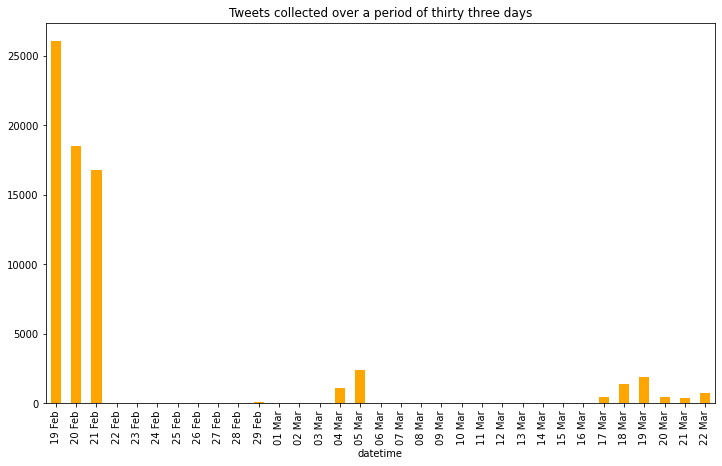

In [44]:
tweets_over_time = tweets[['datetime','timestamp']].groupby(pd.Grouper(key='datetime', freq='D')).size()
graph = tweets_over_time.plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title('Tweets collected over a period of thirty three days')
graph.set_xticklabels(map(lambda x: x.strftime("%d %b"), tweets_over_time.index))
plt.show()

To see how peoples sentiment changes over time, data was collected over a period of 33 days in three batches. Each batch has data of roughly 60 to 120 hours.

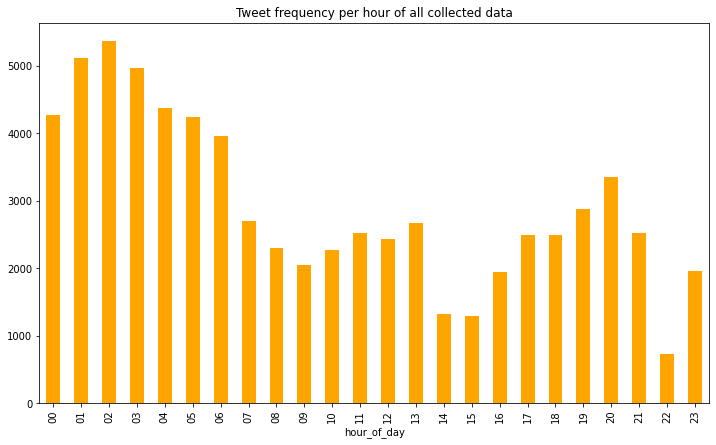

In [45]:
tweets['hour_of_day'] = tweets['datetime'].apply(lambda x: str(x)[11:13])
tweets[['hour_of_day','datetime']].groupby('hour_of_day').size().plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title('Tweet frequency per hour of all collected data')
plt.show()

Plotting number of tweets over 24 hours each day to understand when people tweet the most.

## Percentage of retweets in tweets

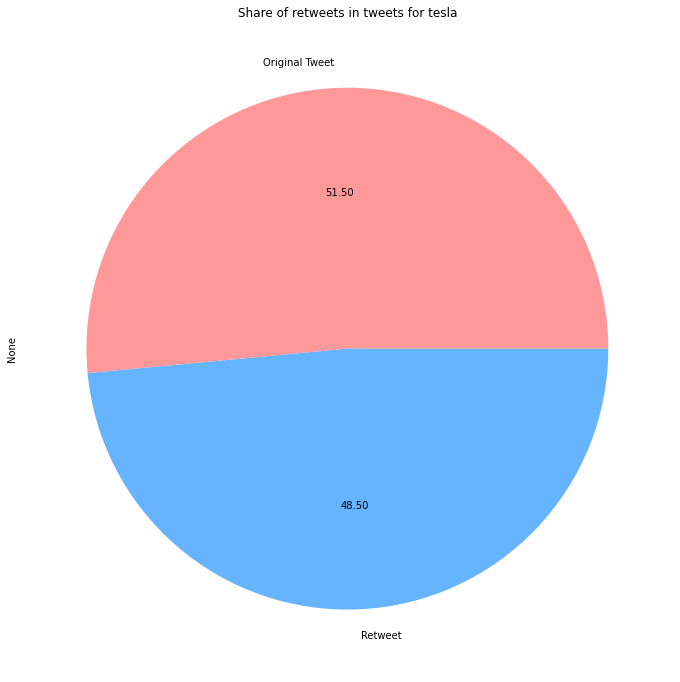

In [46]:
tweet_retweet_share = tweets[['is_retweet','user']].groupby('is_retweet').size()
tweet_retweet_share.index = ['Original Tweet', 'Retweet']
tweet_retweet_share.plot(kind='pie', autopct='%.2f', colors=colors, figsize=(12,12))
plt.title(f'Share of retweets in tweets for {TARGET}')
plt.show()

This chart shows that about half of our tweets are retweets. People retweet something when they endorse it, thus asserting the same sentiment as original tweet more strongly in our data.

## Analysis of tweet text

### Most used words

In [47]:
import nltk
from nltk.text import Text
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

tokenizer = TweetTokenizer()

all_clean_text = []
for text in tweets['clean_text']:
  for word in tokenizer.tokenize(text.lower()):
    if word not in stop_words:
      all_clean_text.append(word)
all_clean_text = ' '.join(all_clean_text)

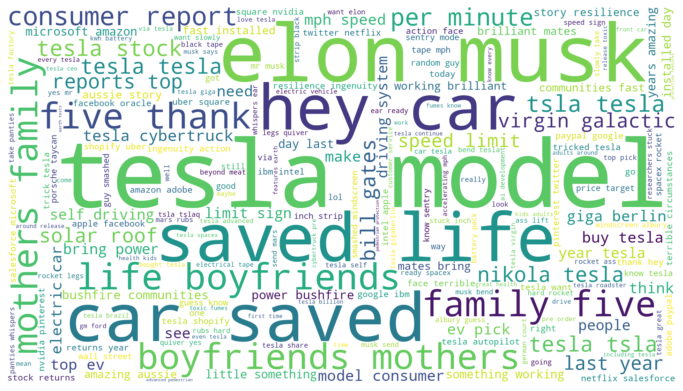

In [48]:
plt.figure(figsize=FIGURE_SIZE)
wordcloud = WordCloud(background_color="white", width=1920, height=1080).generate(all_clean_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This wordcloud shows the most used words in tweets for this company. The wordcloud also makes collocations, showing words which are frequently used together.

Some other words can also be seen which had been trending during that time.

### Most used Hashtags

In [49]:
tokenizer = TweetTokenizer()

all_text = []
for text in tweets['text']:
  for word in tokenizer.tokenize(text.lower()):
    if word not in stop_words:
      all_text.append(word)
all_text = ' '.join(all_text)

In [50]:
HASHTAG_PATTERN = re.compile(r'#\w*')
all_hashtags = ' '.join(HASHTAG_PATTERN.findall(str(all_text)))

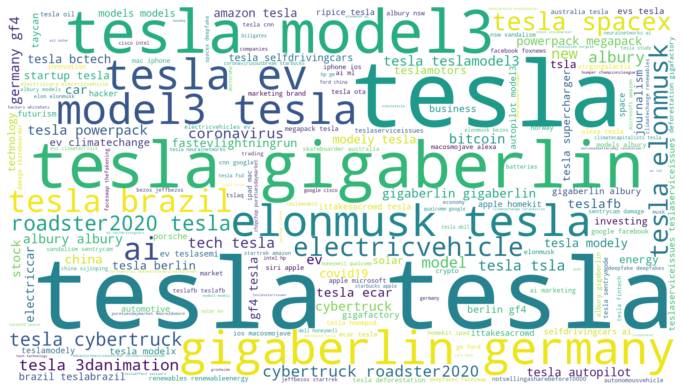

In [51]:
plt.figure(figsize=FIGURE_SIZE)
wordcloud = WordCloud(background_color="white", width=1920, height=1080).generate(all_hashtags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis

In [52]:
def get_sentiment(text):
    return TextBlob(text).sentiment

In [53]:
%%time
sentiment = tweets['clean_text'].apply(lambda x: get_sentiment(x))
tweets['polarity'] = sentiment.apply(lambda x: x[0])
tweets['subjectivity'] = sentiment.apply(lambda x: x[1])

CPU times: user 46.2 s, sys: 2.33 s, total: 48.6 s
Wall time: 50.4 s


In [54]:
tweets[['text','polarity','subjectivity']].head()

,text,polarity,subjectivity
0,Highlight: “We’re seeing Tesla up another 6% t...,0.000000,0.066667
1,Elon Musk calls Bill Gates ‘underwhelming’ htt...,0.000000,0.000000
2,@ATNX143 @slicctor @CNN And accept the fact th...,0.033333,0.208333
3,"A Home Solar Veteran Talks Batteries, Smart Ho...",0.238095,0.380952
4,@JohnTitor33621 My great great grandpa. \r\n\r...,0.800000,0.750000


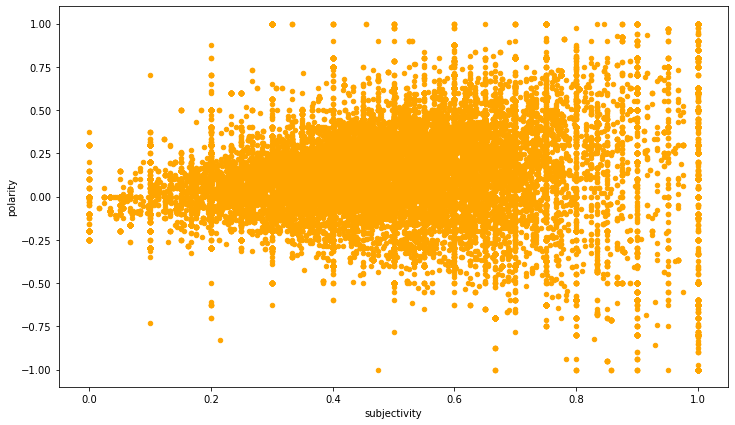

In [55]:
tweets[['polarity','subjectivity']].plot(kind='scatter', x='subjectivity', y='polarity',figsize=FIGURE_SIZE, color='orange')
plt.show()

From the above graph we can see, as the polarity becomes extreme, the subjectivity also increases. That is, more a person is opinionated, more subjective there views are.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e07c40048>,
      dtype=object)

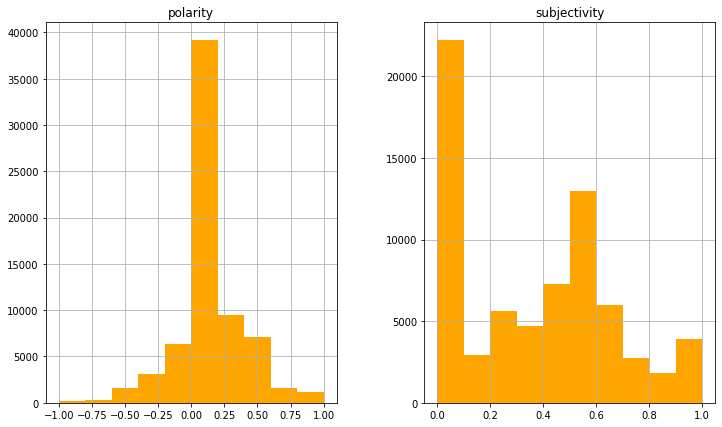

In [56]:
tweets[['polarity','subjectivity']].hist(figsize=FIGURE_SIZE, color='orange')

Histogram for polarity and subjectivity shows that, most tweets have a polarity score of around 0, with a bias towards positive values and subjectivity score many around 0 but more around 0.4 to 0.6. This shows that most tweets have a neutral sentimnt with some being positive and most tweets are subjective, that is, people are more emotionally involved with the brand.

### Sentiment Over Time

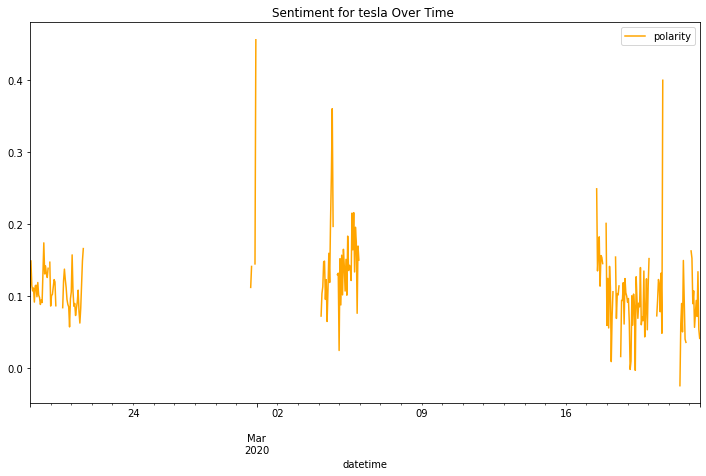

In [57]:
tweets[['datetime','polarity']].groupby(pd.Grouper(key='datetime', freq='H'))\
.mean().plot(figsize=FIGURE_SIZE, color='orange')
plt.title(f'Sentiment for {TARGET} Over Time ')
plt.show()

From the above graph we can see that the sentiment remains mostly positive over the period of 33 days. 

### Top Twitter Clients

In [58]:
client_popularity = tweets[['polarity','source_device']].groupby('source_device').size().sort_values(ascending=False)

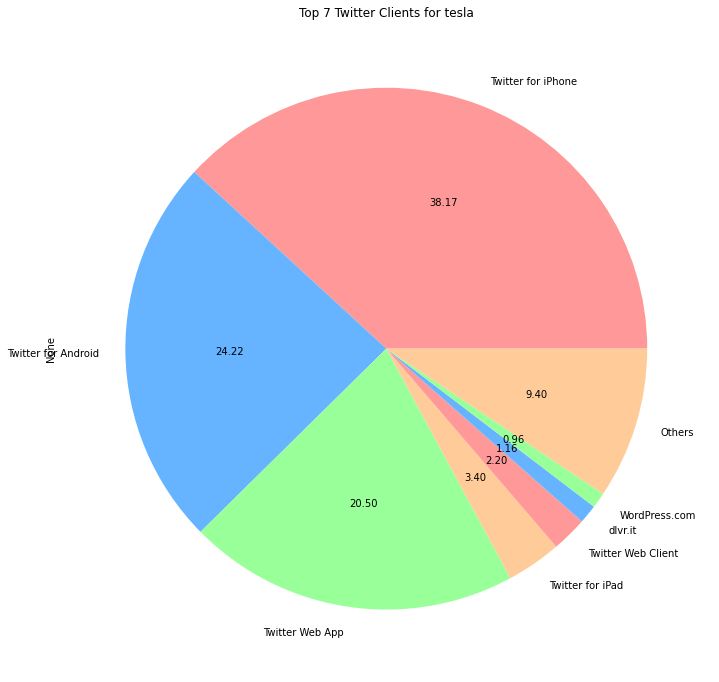

In [59]:
client_popularity[:7].append(pd.Series(client_popularity[7:].sum(), index=['Others']))\
.plot(kind='pie', autopct='%.2f', colors=colors, figsize=(12,12))
plt.title(f'Top 7 Twitter Clients for {TARGET}')
plt.show()

This chart shows the most prefered twitter clients for people tweeting about this company.

### Average Sentiment of people using particular twitter clients

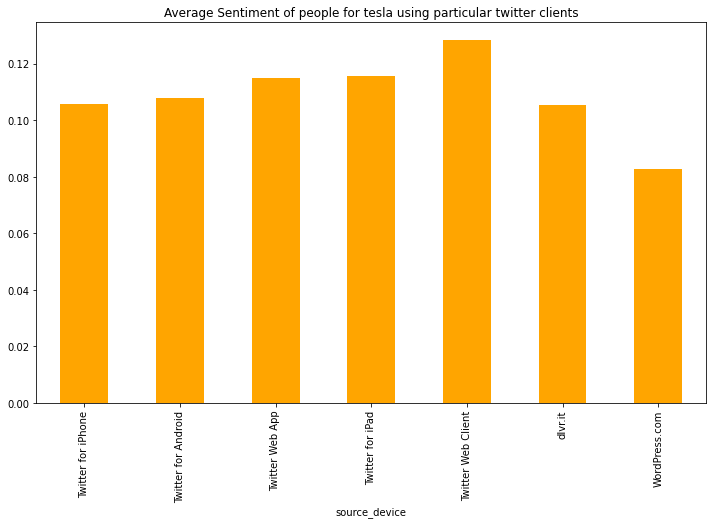

In [60]:
tweets[['datetime','polarity','source_device']].groupby('source_device').agg({
    'polarity': ['size', 'mean']
}).sort_values(('polarity','size'), ascending=False)[('polarity','mean')][:7]\
.plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title(f'Average Sentiment of people for {TARGET} using particular twitter clients')
plt.show()

### Most tweeting countries

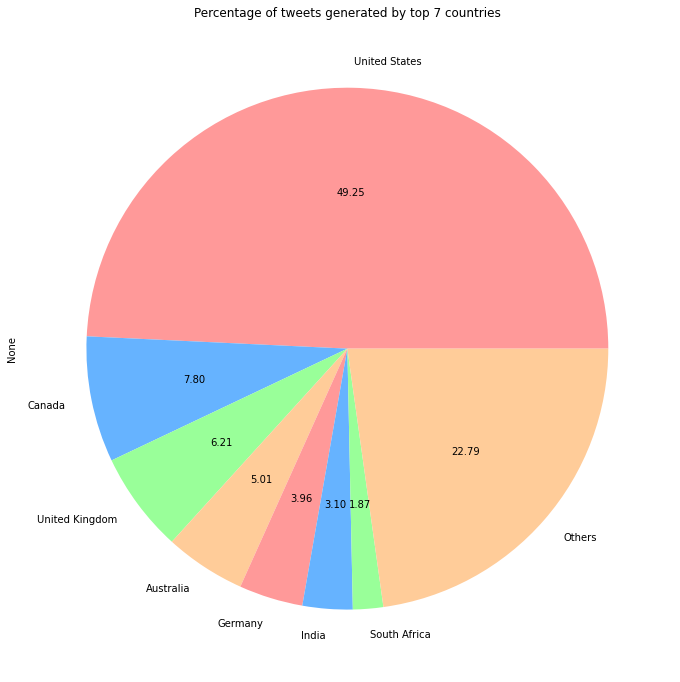

In [61]:
most_tweet_countries = tweets[['country','polarity']].groupby('country').agg({'polarity':['size','mean']}).sort_values(('polarity','size'), ascending=False)[('polarity','size')]
top_7_countries = most_tweet_countries[:7]
top_7_countries.index = top_7_countries.index.map(lambda x: pycountry.countries.get(alpha_2=x).name)
most_tweet_countries = top_7_countries.append(pd.Series(most_tweet_countries[7:].sum(), index=['Others']))
most_tweet_countries.plot(kind='pie', autopct='%.2f', colors=colors, figsize=(12,12))
plt.title('Percentage of tweets generated by top 7 countries')
plt.show()

### Sentiment of people in countries tweeting most

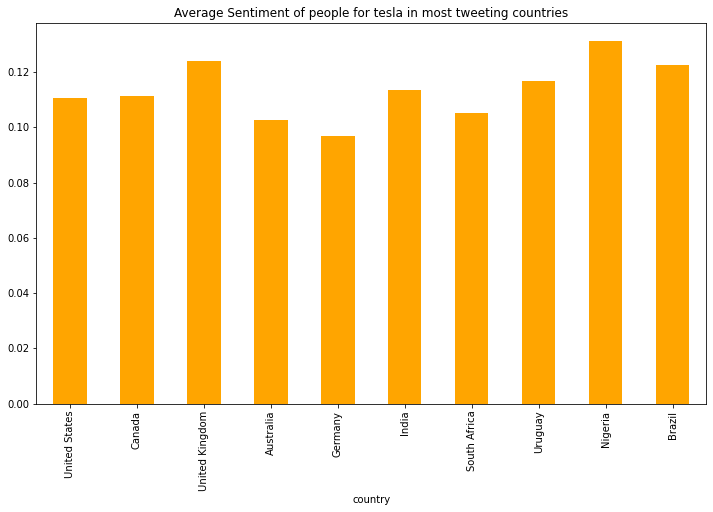

In [62]:
most_tweet_countries = tweets[['country','polarity']].groupby('country')\
.agg({'polarity':['size','mean']}).sort_values(('polarity','size'), ascending=False)[:10]
most_tweet_countries.index = most_tweet_countries.index.map(lambda x: pycountry.countries.get(alpha_2=x).name)
most_tweet_countries[('polarity','mean')].plot(kind='bar', figsize=FIGURE_SIZE, color='orange')
plt.title(f'Average Sentiment of people for {TARGET} in most tweeting countries')
plt.show()